# Experiment 1A2H

In this notebook we show how the evaluation for single system can give very different results depending on the human raters. 

In [178]:
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

import numpy as np

import itertools

from rsmtool.utils.prmse import prmse_true

import json

%matplotlib inline

In [179]:
config = json.load(open('settings.json'))

In [180]:
df = pd.read_csv('../data/data.csv')
df_raters = pd.read_csv('../data/raters.csv')
df['system'] = df[config['sample_system']]

In [181]:
# generate pairs of raters for each group

def generate_rater_pairs_for_group(df_group, n_pairs):
    raters = df_group['rater_id']
    # get all possible rater pairs
    rater_pairs = ['{}+{}'.format(p[0], p[1]) for p in itertools.combinations(raters, 2)]
    np.random.seed(100)
    selected_pairs = np.random.choice(rater_pairs, n_pairs, replace=False)
    return selected_pairs

In [182]:
# randomly sample 50 pairs for each group
selected_pairs = df_raters.groupby('category').apply(generate_rater_pairs_for_group, n_pairs=50)
pair_dict = selected_pairs.to_dict()

In [183]:
# we make one long DF to speed up computation
data = []
for category in pair_dict:
    pairs = pair_dict[category]
    for p in pairs:
        (h1, h2) = p.split('+')
        df_p = pd.DataFrame({'pair': p,
                             'category': category,
                              'h1': df[h1],
                              'h2': df[h2],
                              'system': df['system']})
        data.append(df_p)
    df_long = pd.concat(data)

In [184]:
# compute mean score
df_long['h_mean'] = (df_long['h1'] + df_long['h2'])/2

## Correlations

In [185]:
true_corr = pearsonr(df['system'], df['true'])[0]
true_corr

0.9124287935322448

In [186]:
# let's compute correlations between each pair and the system score
df_corr = df_long.groupby('pair').corr().unstack().sort_values(by=('h1', 'h2'))
df_corr.columns = ['_'.join(col) for col in df_corr.columns]
len(df_corr)

200

In [187]:
df_corr_with_category = pd.merge(df_corr, df_long[['pair', 'category']].drop_duplicates(), 
                                 left_index=True, right_on='pair')
len(df_corr_with_category)

200

Text(0, 0.5, 'Correlation between system and mean H')

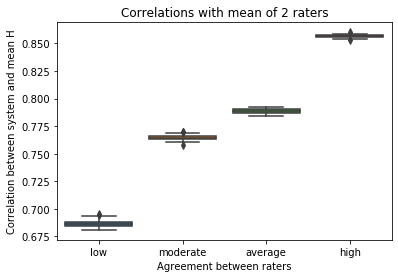

In [188]:
ax=sns.boxplot(x='category', y='h_mean_system', data=df_corr_with_category)
ax.set_title("Correlations with mean of 2 raters")
ax.set_xlabel("Agreement between raters")
ax.set_ylabel("Correlation between system and mean H")

## R2

In [189]:
# baseline: system r2 with true score.
true_r2 = r2_score(df['true'], df['system'])
true_r2

0.7998688213787986

In [190]:
df_r2 = pd.DataFrame(df_long.groupby('pair').apply(lambda x: r2_score(x['h_mean'], x['system'])))
df_r2.columns=['value']
df_r2['Metrics'] = 'R2_mean'

In [191]:
df_r2_h1 = pd.DataFrame(df_long.groupby('pair').apply(lambda x: r2_score(x['h1'], x['system'])))
df_r2_h1.columns=['value']
df_r2_h1['Metrics'] = 'R2_h1'

In [192]:
df_prmse = pd.DataFrame(df_long.groupby('pair').apply(lambda x: prmse_true(x['system'],
                                                              x[['h1', 'h2']])))
df_prmse.columns = ['value']
df_prmse['Metrics'] = 'PRMSE'

In [193]:
df_res = pd.concat([df_r2, df_prmse], sort=True)

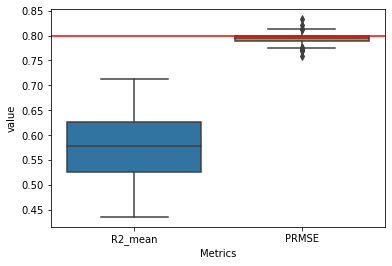

In [194]:
ax=sns.boxplot(x='Metrics', y='value', data=df_res)
ax.axhline(true_r2, color='red')

In [195]:
df_res.groupby('Metrics')['value'].describe()

,count,mean,std,min,25%,50%,75%,max
Metrics,,,,,,,,
PRMSE,200.0,0.794127,0.009658,0.758263,0.789338,0.794632,0.798613,0.832655
R2_mean,200.0,0.576456,0.092771,0.435272,0.525517,0.577507,0.626730,0.713022


In [196]:
df_with_h = pd.merge(df_res, df_corr_with_category, left_index=True, right_on='pair')
len(df_with_h)

400

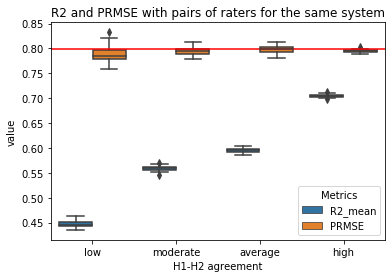

In [197]:
ax = sns.boxplot(x='category', y='value', hue="Metrics", data=df_with_h.sort_values('value'))
ax.axhline(true_r2, color='red')
ax.set_title("R2 and PRMSE with pairs of raters for the same system")
ax.set_xlabel("H1-H2 agreement");